In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

import json
import os
import imantics
import random
import collections

from PIL import Image
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.ndimage import label

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Concatenate, Dropout, Conv2DTranspose, concatenate, AveragePooling2D,Activation,UpSampling2D,BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
%matplotlib inline


# Load Dataset

In [3]:
annote_dir = 'data/instances_default.json'
images_dir = 'data/images' 

In [4]:
image_size = 512
input_image_size = (1920, 1080)

In [5]:
images_listdir = os.listdir(images_dir)

In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

# Dataset

In [9]:
annote = json.load(open(annote_dir))

In [10]:
id_to_images = {image['id']:image['file_name'] for image in annote['images']}

In [11]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

In [12]:
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)
    # cur_mask = cur_mask.astype(np.uint8) 
    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

# Players Team Classification 

## Approach: Multiclass Segmentation

In [15]:
masked_images = []
for i in range(len(masks)):
    temp_mask = np.copy(masks[i])
    temp_mask = temp_mask.astype(np.uint8) 
    temp_image = np.copy(images[i])
    temp_masked_image = cv2.bitwise_and(temp_image, temp_image, mask=temp_mask)
    masked_images.append(temp_masked_image)
    

### First We will extract the teams colors 

In [16]:
# Define the target color and threshold for each team
team_a_color = np.array([129, 239, 252]) 
team_b_color = np.array([170, 25, 50]) 
ref_color = np.array([30, 50, 90]) 

# The distance from the center color for the team
distance_a = 60  
distance_b = 60 
distance_ref = 30

# The team color in the multilass mask
class_a_color = 200 
class_b_color = 150
class_ref_color = 40


In [17]:
# Create inverted masks
inverted_masks = []
for i in range(len(masks)):
    temp_inv = masks[i].copy()
    temp_inv =  temp_inv.astype(np.uint8)
    temp_inv[temp_inv == 0 ] = 255
    temp_inv[temp_inv == 1 ] = 0
    inverted_masks.append(temp_inv)

In [18]:

def extractTeamColor(image, target_color, threshold, class_color):
    # Calculate the Euclidean distance between each pixel and the target color
    color_distance = np.linalg.norm(image - target_color, axis=2)

    color_mask = color_distance < threshold
    
    extracted_image = np.zeros_like(image)
    extracted_image[color_mask] = image[color_mask]

    # Assign the class color to each channel of the extracted image
    for i in range(extracted_image.shape[2]):
        extracted_image[..., i][extracted_image[..., i] != 0] = class_color

    return extracted_image

In [19]:

def recolorWithMask(image):
    dark_gray = [10, 10, 10]  
    black = [0, 0, 0]  

    black_pixels_mask = np.all(image == black, axis=2)
    white_pixels_mask = np.all(image == [255, 255, 255], axis=2)
    
    image[black_pixels_mask] = dark_gray
    image[white_pixels_mask] = black

    return image


def recolorFinalClassesMask(image):
    red = [255, 0, 0]  
    blue = [0, 0, 255]  
    green = [0, 255, 0]  
    black = [0, 0, 0]
    yellow = [255, 255, 0]
    
    #-----------------------
    team_a = [200, 200, 200]  
    team_b  =[150, 150, 150]  
    #ref_color = [40, 40, 40]
    #====
    comb1 =[94, 94, 94]
    '''comb2 = [240, 240, 240]
    comb3 = [140, 140, 140]
    comb4 = [136, 136, 136]'''
    
    teamA_pixels_mask = np.all(image == team_a, axis=2)
    teamB_pixels_mask = np.all(image == team_b, axis=2)
    other_pixels_mask = np.all(image == comb1, axis=2)
    #otherMask = np.all((image == comb2) or(image == comb1)  , axis=2)
    
    '''colors = [comb1, comb2, comb3, comb4]
    combined_mask = np.zeros(image.shape[:2], dtype=bool)

    for color in colors:
        mask = np.all(image == color, axis=2)
        combined_mask = np.logical_or(combined_mask, mask)'''
    
    image[teamA_pixels_mask] = blue
    image[teamB_pixels_mask] = red
    #image[ref_pixels_mask] = green
    image[other_pixels_mask] = black

    return image

In [20]:
def createClassMask(image, team_color):
    # Find connected regions
    labels, num_features = label(np.any(image != 0, axis=-1))
    # Loop through each connected region
    for i in range(1, num_features + 1):
        mask = (labels == i)

        # Get the colors in the region
        region_colors = image[mask]
       
        flat_array = region_colors.flatten()
        #print(flat_array)
        vals, counts = np.unique(flat_array, return_counts=True)
        for val, count in zip(vals, counts):
            #print(f'{val} occurs {count} times')
            if val == team_color  and count > 150:
                image[mask] = team_color
            elif (val == team_color  and count < 150) or len(vals) == 1:
                image[mask] = 0

    return image

In [100]:
team_a_masks = []
team_b_masks = []
final_masks = []

for i in range(len(masked_images)):
    extracted_color_A = extractTeamColor(masked_images[i], team_a_color, distance_a, class_a_color)
    new_im_a = extracted_color_A + inverted_masks[i]
    recolor_a = recolorWithMask(new_im_a.copy())
    team_a_mask = createClassMask(recolor_a.copy(),class_a_color)
    team_a_masks.append(team_a_mask)
    #----
    extracted_color_B = extractTeamColor(masked_images[i], team_b_color, distance_b, class_b_color)
    new_im_b = extracted_color_B + inverted_masks[i]
    recolor_b = recolorWithMask(new_im_b.copy())
    team_b_mask = createClassMask(recolor_b.copy(),class_b_color)
    team_b_masks.append(team_b_mask)
     #----
    '''extracted_color_ref = extractTeamColor(masked_images[i], ref_color, distance_ref, class_ref_color)
    new_im_ref = extracted_color_ref + inverted_masks[i]
    recolor_ref = recolorWithMask(new_im_ref.copy())
    team_ref_mask = createClassMask(recolor_ref.copy(), class_ref_color)'''
    
    final_mask = team_a_mask + team_b_mask # + team_ref_mask
    final_masks.append(final_mask)
    

In [101]:
for i in range(len(masked_images)):
    final_masks[i] = recolorFinalClassesMask(final_masks[i] )

In [103]:
for i, image in enumerate(final_masks):
    filename = f"data/masks/mask_{i}.jpg" 
    plt.imsave(filename, image)

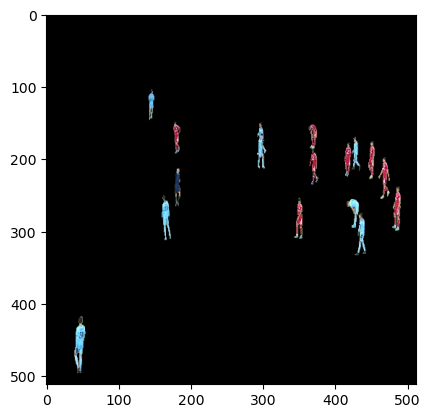

In [104]:
plt.imshow(masked_images[0])

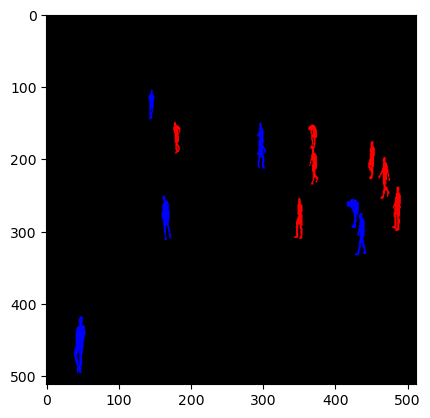

In [102]:
plt.imshow(final_masks[0])

# Players Roles

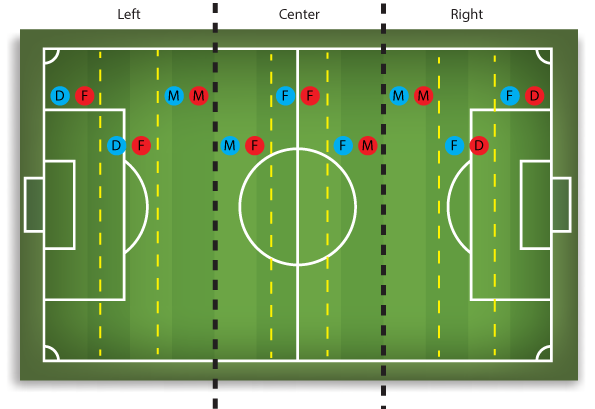

### Field Lines extraction

In [121]:
def detectLinesCircles(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([90, 255, 255])

    mask = cv2.inRange(hsv, lower_green, upper_green)
    blurred_mask = cv2.GaussianBlur(mask, (5, 5), 0)

    edges = cv2.Canny(mask, 50, 150)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    side_list = []
    for line in lines:
        rho, theta = line[0]

        slope = np.tan(theta)
        #print(slope)
        if slope < -0.5:
            side = "Left"
        elif slope > 0.5:
            side = "Right"
        else:
            side = "Center"
        
        side_list.append(side)
        
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    '''# Hough circle transform to detect circles 
    value = hsv[:,:,2]
    circles = cv2.HoughCircles(blurred_mask, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=50, param2=30, minRadius=0, maxRadius=0)

    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)

        filtered_circles = []
        for (x, y, r) in circles:
            if mask[y, x] != 0:
                filtered_circles.append((x, y, r))

        for (x, y, r) in filtered_circles:
            cv2.circle(image, (x, y), r, (0, 255, 0), 2)'''
            
    isCenter = any(item in 'Center' for item in side_list)

    if isCenter:
        field_side = 'Center'
    else:
        sorted_lines = [item for items, c in Counter(side_list).most_common()
                                  for item in [items] * c]
        field_side =  sorted_lines[0]

    return image, field_side


In [123]:
image1 = images[50].copy()
image1_lines, field_side = detectLinesCircles(image1)

field_side

'Left'

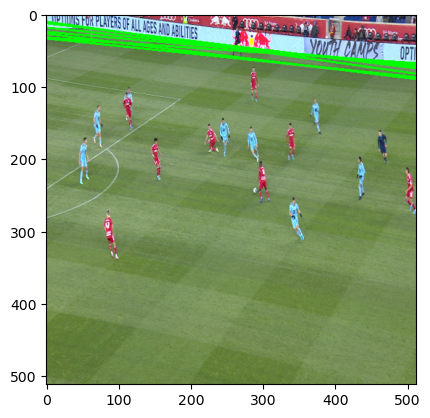

In [124]:
plt.imshow(image1_lines)

### Classify the Players Roles 

I used the field_side output from the previous step to assign the players roles

In [ ]:
def getPlayersRegions(mask):
  
    labels, num_features = label(np.any(mask != 0, axis=-1))
    player_regions = []
    for label_id in range(1, num_features + 1):
        component_mask = (labels == label_id)
        contours, _ = cv2.findContours(component_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bounding_rect = cv2.boundingRect(contours[0])
        player_regions.append(bounding_rect)

    return player_regions


def getPlayersRoles(player_regions, field_side, team_a_count, team_b_count):
    roles = []
    team_a = np.full(team_a_count, 'a')
    team_b = np.full(team_b_count, 'b')
    
    teams_tag = np.concatenate([team_a , team_b])
    
    for region , team in zip(player_regions, teams_tag):
        x, y, w, h = region
        center_x = x + w // 2

        # Determine the player's role based on their location on the field side
        
        if field_side == "Left" :
            if team == 'b':
                if center_x > 340:
                    role = "Midfielder"
                else:
                    role = "Forward"
            else: 
                if center_x <= 340:
                     role = "Defender"
                elif center_x > 340:
                    role = "Midfielder"
                    
        elif field_side == "Right" :
            if team == 'a':
                if center_x < 170:
                    role = "Midfielder"
                else:
                    role = "Forward"
            else: 
                if center_x >= 170:
                     role = "Defender"
                elif center_x < 170:
                    role = "Midfielder"
                    
        elif field_side == "Center":
            if team == 'a':
                if center_x < 170:
                    role = "Midfielder"
                elif  center_x >= 170 :
                    role = "Forward"
            else:
                if center_x < 340:
                    role = "Forward"
                elif  center_x >= 340 :
                    role = "Midfielder"

        roles.append(role)

    return roles

def addPlayersRoles(image, regions, roles):
    for region, role in zip(regions, roles):
        x, y, w, h = region
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2) 
        text = getRoleInitial(role)  
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  

def getRoleInitial(role):
    if role == "Forward":
        return "F"
    elif role == "Midfielder":
        return "M"
    elif role == "Defender":
        return "D"
    else:
        return "N/A"

In [96]:

team_a_regions = getPlayersRegions(team_a_masks[450])  
team_b_regions = getPlayersRegions(team_b_masks[450])  

all_regions = team_a_regions + team_b_regions

team_a_count = len(team_a_regions)
team_b_count = len(team_b_regions)

player_roles = getPlayersRoles(all_regions, field_side, team_a_count, team_b_count)

original_image = images[450].copy()

addPlayersRoles(original_image, all_regions, player_roles)

# Print the roles of players for both teams
print("Team A:")
for i, role in enumerate(player_roles[:len(team_a_regions)]):
    print(f"Player {i+1}: {role}")

print("\nTeam B:")
for i, role in enumerate(player_roles[len(team_a_regions):]):
    print(f"Player {i+1}: {role}")

Team A:
Player 1: Defender
Player 2: Defender
Player 3: Midfielder
Player 4: Defender
Player 5: Defender
Player 6: Midfielder

Team B:
Player 1: Midfielder
Player 2: Forward
Player 3: Forward
Player 4: Midfielder
Player 5: Forward
Player 6: Forward
Player 7: Forward
Player 8: Midfielder


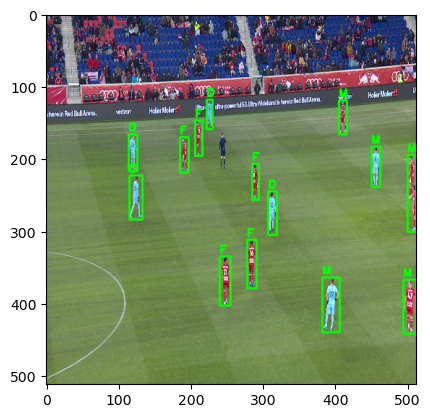

In [97]:
plt.imshow(original_image)

# Game Statistics

### Approach 1

In [125]:
field_side_list = []

for i in range(len(images)):
    temp_img = images[i].copy()
    temp_img_lines, field_side = detectLinesCircles(temp_img)
    field_side_list.append(field_side)

In [128]:

frequency = collections.Counter(field_side_list)

print(dict(frequency))


{'Right': 137, 'Left': 165, 'Center': 210}


In [135]:
total_attemps = frequency['Right'] + frequency['Left']
team_a_time = frequency['Right']/total_attemps*100
team_b_time = frequency['Left']/total_attemps*100

In [138]:
print('Blue team possession: ', round(team_a_time, 2),'%')
print('Red team possession: ',  round(team_b_time, 2),'%')


Blue team possession:  45.36 %
Red team possession:  54.64 %


### Approach 2 - Optical Flow

# Pose Estimation

In [3]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [4]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [5]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [10]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [11]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 2, (0,255,0), -1)

In [16]:
cap = cv2.VideoCapture('data/football_game.mp4')

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

'''output_filename = 'football_game_keypoints.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))'''

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize image
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    out.write(frame)
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

========================================================

# GoalKeeper 1

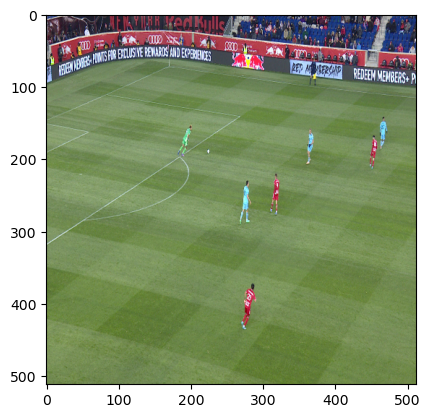

In [403]:
plt.imshow(images[200])

In [387]:
maskgk1 = np.copy(masks[200])
imagegk1 = np.copy(images[200])

In [388]:
maskgk1 = maskgk1.astype(np.uint8) 

In [389]:
maskgk1 [maskgk1 == 0] = 255

In [390]:
maskgk1 [maskgk1 == 1] = 0

In [391]:
maskedgk1_image  = createMaskedImages(imagegk1, maskgk1 )

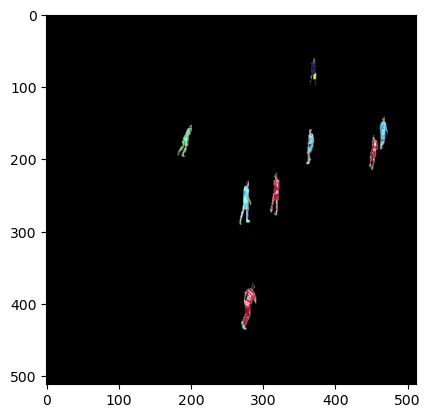

In [392]:
plt.imshow(maskedgk1_image)

In [398]:
# Define the target color and threshold
goalkeeper1_color = np.array([110, 220, 150])  
threshold_goalkeeper1 = 50  
class_goalkeeper1_color = 160

extracted_image_goalkeeper1 = colorMask(maskedgk1_image, goalkeeper1_color, threshold_goalkeeper1, class_goalkeeper1_color)

In [399]:
newim_gk1 = extracted_image_goalkeeper1+maskgk1

In [400]:
redimg_gk1 = recolor_black_pixels_to_red_and_white_pixels_to_black(newim_gk1.copy())

In [401]:
mostfeq_gk1 = color_most_frequent_regions2(redimg_gk1.copy(), 160)

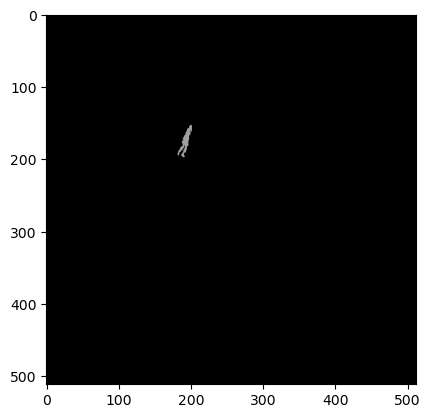

In [402]:
plt.imshow(mostfeq_gk1)

# Failed Atttempts

## Clustering 

In [ ]:
def getColorHistogram(image):
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    histogram = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    histogram = cv2.normalize(histogram, histogram).flatten()
    
    return histogram

def classifyObjects(image, mask):
    object_classes = []
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract the object from the image using the bounding rectangle
        object_image = image[y:y+h, x:x+w]
        
        # Extract the color histogram of the object
        histogram = getColorHistogram(object_image)
        
        # Store the histogram, coordinates, and label in the object_classes list
        object_classes.append({"histogram": histogram, "coords": (x, y, x+w, y+h), "label": None})
    
    return object_classes

def drawBBoxes(image, object_classes, class_labels):
    print(len(object_classes))
    for obj in object_classes:
        coords = obj["coords"]
        label = class_labels[obj["label"]]
        
        cv2.rectangle(image, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 2)
        cv2.putText(image, label, (coords[0], coords[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

In [169]:

object_classes = classifyObjects(image2, mask2)

class_labels = {0: " A", 1: "B"}

for i, obj in enumerate(object_classes):
    obj["label"] = i % len(class_labels)

output_image = drawBBoxes(image2.copy(), object_classes, class_labels)


14


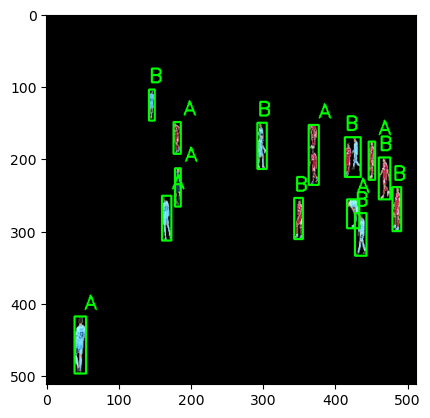

In [170]:
plt.imshow(output_image)

# Multiclass Mask

Approach: finding connected areas (players), find the most frequent color, then recolor the entire area with that color
Problem: the dynamic environment changed the playes uniform color drastically.

In [77]:
def colorMostFrequent(image):
    
    labels, num_features = label(np.any(image != 0, axis=-1))
    for i in range(1, num_features + 1):
        mask = (labels == i)

        region_colors = image[mask]

        if len(region_colors) > 0:
            most_frequent_color = np.bincount(region_colors.reshape(-1, 3).argmax(axis=1)).argmax()
            image[mask] = region_colors[most_frequent_color]

    return image

In [78]:
new_image = colorMostFrequent(np.copy(masked_image))

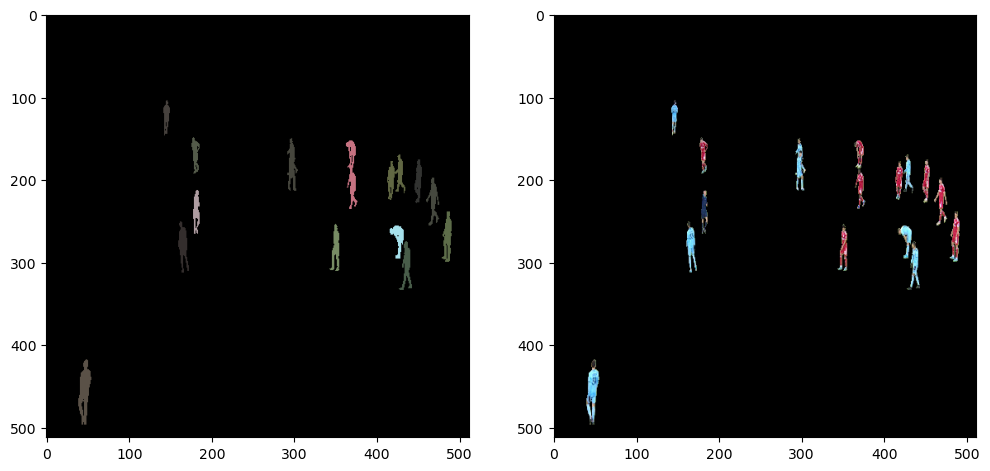

In [79]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(new_image)
ax[1].imshow(masked_image)

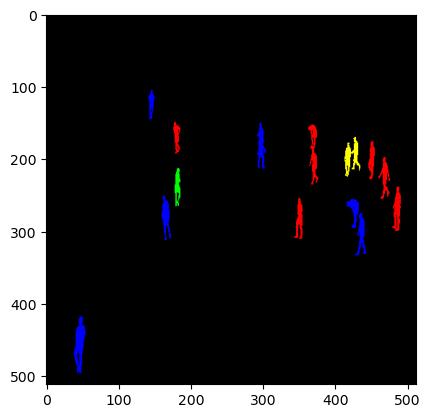

In [153]:
plt.imshow(final_masks[0])

# Multiclass Segmentation with U-Net

I had to run the unet code on kaggle for faster computation. the results are in the the other Notebook "Unet_Multiclass_Segmentation".


In [149]:

masked_images = np.array(masked_images) / 255.0
final_masks = np.array(final_masks) / 255.0

# Split the data into training and testing sets
split = int(0.8 * len(masked_images))
train_images, test_images = masked_images[:split], masked_images[split:]
train_masks, test_masks = final_masks[:split], final_masks[split:]


In [150]:

from tensorflow.keras import layers

# Define the U-Net model architecture
def unet(input_size):
    inputs = tf.keras.Input(input_size)

    # Contracting path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Expanding path
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(3, 1, activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [151]:

# Create U-Net model
model = unet((512, 512, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
model.fit(train_images, train_masks, batch_size=16, epochs=1, validation_data=(test_images, test_masks), verbose=1)


In [ ]:

# Perform segmentation on a test image
test_image = masked_images[0]
segmentation_result = model.predict(np.expand_dims(test_image, axis=0))

# You can further process the segmentation result or visualize it as desired